# TPC DS scale factor 10 - Apache Spark acceleration on GPU with RAPIDS Spark

based on https://colab.research.google.com/github/LucaCanali/Miscellaneous/blob/master/Performance_Testing/TPCDS_PySpark/Labs_and_Notes/TPCDS_PySpark_getstarted.ipynb#scrollTo=6bab7772

# Install packages

In [36]:
spark_version='3.5.0'
rapids_version='24.10.0'
scala_version='2.12'

In [37]:
%pip install --quiet \
  tpcds_pyspark \
  pyspark=={spark_version} \
  sparkmeasure \
  pandas \
  matplotlib

Note: you may need to restart the kernel to use updated packages.


# Import modules

In [38]:
from importlib.resources import files
from pyspark.sql import SparkSession
from tpcds_pyspark import TPCDS
import os
import pandas as pd
import time

In [39]:
tpcds_pyspark_files = files('tpcds_pyspark')

# Download TPC-DS 10GiB Scale Parquet Dataset

In [40]:
if not os.path.isdir('tpcds_10'):
  if not os.path.isfile('tpcds_10.zip'):
    !wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/TPCDS/tpcds_10.zip
  !unzip -q tpcds_10.zip

# Init a SparkSession with RAPIDS Spark

In [41]:
spark = (
    SparkSession.builder
      .appName('TPCDS PySpark RAPIDS=ON/OFF')
      .config('spark.driver.memory', '5g')
      .config('spark.plugins', 'com.nvidia.spark.SQLPlugin')
      .config('spark.jars', tpcds_pyspark_files.joinpath(f"spark-measure_{scala_version}-0.24.jar"))
      .config('spark.jars.packages', f"com.nvidia:rapids-4-spark_{scala_version}:{rapids_version}")
      .getOrCreate()
)


24/10/22 18:16:40 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Verify SQL Acceleration on GPU can be enabled by checking the query plan and the GPU RAM in the "Resources" tab

In [42]:
spark.conf.set('spark.rapids.sql.enabled', True)
sum_df = spark.range(1000).selectExpr('SUM(*)')
sum_df.collect()
sum_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=true
+- == Final Plan ==
   GpuColumnarToRow false, [loreId=22]
   +- GpuHashAggregate (keys=[], functions=[gpubasicsum(id#182218L, LongType, false)]), filters=ArrayBuffer(None)) [loreId=21]
      +- GpuShuffleCoalesce 1073741824, [loreId=20]
         +- ShuffleQueryStage 0
            +- GpuColumnarExchange gpusinglepartitioning$(), ENSURE_REQUIREMENTS, [plan_id=886390], [loreId=17]
               +- GpuHashAggregate (keys=[], functions=[partial_gpubasicsum(id#182218L, LongType, false)]), filters=ArrayBuffer(None)) [loreId=16]
                  +- GpuRange (0, 1000, step=1, splits=64)
+- == Initial Plan ==
   HashAggregate(keys=[], functions=[sum(id#182218L)])
   +- Exchange SinglePartition, ENSURE_REQUIREMENTS, [plan_id=886337]
      +- HashAggregate(keys=[], functions=[partial_sum(id#182218L)])
         +- Range (0, 1000, step=1, splits=64)




In [43]:
# https://github.com/LucaCanali/Miscellaneous/tree/master/Performance_Testing/TPCDS_PySpark/tpcds_pyspark/Queries

# queries = None to run all (takes much longer)
queries = None
queries = [
    'q14a',
    'q14b',
    'q23a',
    'q23b',
    # 'q24a',
    # 'q24b',
    'q88',
]


# TPCDS App

In [44]:
demo_start = time.time()
tpcds = TPCDS(data_path='./tpcds_10', num_runs=1, queries_repeat_times=1, queries=queries)

sparkMeasure jar path: /home/gshegalov/.local/share/virtualenvs/jupyterlab-E-itHfrh/lib/python3.10/site-packages/tpcds_pyspark/spark-measure_2.12-0.24.jar
TPCDS queries path: /home/gshegalov/.local/share/virtualenvs/jupyterlab-E-itHfrh/lib/python3.10/site-packages/tpcds_pyspark/Queries


24/10/22 18:17:25 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Register TPC-DS tables before running queries

In [45]:
tpcds.map_tables()

Creating temporary view catalog_returns
Creating temporary view catalog_sales
Creating temporary view inventory
Creating temporary view store_returns
Creating temporary view store_sales
Creating temporary view web_returns
Creating temporary view web_sales
Creating temporary view call_center
Creating temporary view catalog_page
Creating temporary view customer
Creating temporary view customer_address
Creating temporary view customer_demographics
Creating temporary view date_dim
Creating temporary view household_demographics
Creating temporary view income_band
Creating temporary view item
Creating temporary view promotion
Creating temporary view reason
Creating temporary view ship_mode
Creating temporary view store
Creating temporary view time_dim
Creating temporary view warehouse
Creating temporary view web_page
Creating temporary view web_site


## Measure Apache Spark CPU

In [46]:
tpcds.spark.conf.set('spark.rapids.sql.enabled', False)
%time tpcds.run_TPCDS()
cpu_grouped_results = tpcds.grouped_results_pdf.copy()
cpu_grouped_results


Run 0 - query q14a - attempt 0 - starting...


Job finished
...Start Time = 2024-10-22 18:18:36
...Elapsed Time = 7.42 sec
...Executors Run Time = 115.76 sec
...Executors CPU Time = 63.91 sec
...Executors JVM GC Time = 39.27 sec
...Average Active Tasks = 15.6

Run 0 - query q14b - attempt 0 - starting...


Job finished
...Start Time = 2024-10-22 18:18:46
...Elapsed Time = 4.53 sec
...Executors Run Time = 76.36 sec
...Executors CPU Time = 49.59 sec
...Executors JVM GC Time = 18.49 sec
...Average Active Tasks = 16.9

Run 0 - query q23a - attempt 0 - starting...


Job finished
...Start Time = 2024-10-22 18:18:52
...Elapsed Time = 7.78 sec
...Executors Run Time = 169.37 sec
...Executors CPU Time = 109.71 sec
...Executors JVM GC Time = 43.06 sec
...Average Active Tasks = 21.8

Run 0 - query q23b - attempt 0 - starting...


Job finished
...Start Time = 2024-10-22 18:19:01
...Elapsed Time = 8.04 sec
...Executors Run Time = 207.58 sec
...Executors CPU Time = 124.36 sec
...Executors JVM GC Time = 65.38 sec
...Average Active Tasks = 25.8

Run 0 - query q88 - attempt 0 - starting...
Job finished
...Start Time = 2024-10-22 18:19:10
...Elapsed Time = 0.77 sec
...Executors Run Time = 31.51 sec
...Executors CPU Time = 20.43 sec
...Executors JVM GC Time = 7.06 sec
...Average Active Tasks = 40.8
CPU times: user 99.8 ms, sys: 22.9 ms, total: 123 ms
Wall time: 36 s


,query,numStages,numTasks,elapsedTime,stageDuration,executorRunTime,executorCpuTime,executorDeserializeTime,executorDeserializeCpuTime,resultSerializationTime,...,shuffleLocalBlocksFetched,shuffleRemoteBlocksFetched,shuffleTotalBytesRead,shuffleLocalBytesRead,shuffleRemoteBytesRead,shuffleRemoteBytesReadToDisk,shuffleBytesWritten,shuffleRecordsWritten,avg_active_tasks,elapsed_time_seconds
0,q14a,30,838,7417,12274,115758,63907,2393,1634,924,...,551,0,878437913,878437913,0,0,875325021,62516924,15,7
1,q14b,24,636,4526,6859,76362,49588,1629,1198,87,...,513,0,1013592969,1013592969,0,0,529675847,40865273,16,4
2,q23a,18,621,7783,13629,169367,109709,1557,1048,75,...,2269,0,1115089630,1115089630,0,0,1085198863,41990073,21,7
3,q23b,21,690,8045,15676,207577,124362,4056,1347,27,...,4779,0,1200330085,1200330085,0,0,1097570340,42452502,25,8
4,q88,26,530,773,4281,31512,20433,196,359,0,...,512,0,28912,28912,0,0,28912,512,40,0


## Measure Apache Spark GPU

In [47]:
tpcds.spark.conf.set('spark.rapids.sql.enabled', True)
%time tpcds.run_TPCDS()
gpu_grouped_results = tpcds.grouped_results_pdf.copy()
gpu_grouped_results


Run 0 - query q14a - attempt 0 - starting...


24/10/22 18:19:13 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-22 18:19:12
...Elapsed Time = 4.66 sec
...Executors Run Time = 88.34 sec
...Executors CPU Time = 14.61 sec
...Executors JVM GC Time = 7.65 sec
...Average Active Tasks = 19.0

Run 0 - query q14b - attempt 0 - starting...


24/10/22 18:19:20 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-22 18:19:20
...Elapsed Time = 2.38 sec
...Executors Run Time = 66.28 sec
...Executors CPU Time = 11.44 sec
...Executors JVM GC Time = 6.65 sec
...Average Active Tasks = 27.8

Run 0 - query q23a - attempt 0 - starting...


24/10/22 18:19:23 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-22 18:19:23
...Elapsed Time = 2.9 sec
...Executors Run Time = 88.17 sec
...Executors CPU Time = 19.27 sec
...Executors JVM GC Time = 6.89 sec
...Average Active Tasks = 30.4

Run 0 - query q23b - attempt 0 - starting...


24/10/22 18:19:28 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-22 18:19:27
...Elapsed Time = 4.53 sec
...Executors Run Time = 170.1 sec
...Executors CPU Time = 21.97 sec
...Executors JVM GC Time = 4.99 sec
...Average Active Tasks = 37.5

Run 0 - query q88 - attempt 0 - starting...


24/10/22 18:19:33 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-22 18:19:33
...Elapsed Time = 1.5 sec
...Executors Run Time = 78.1 sec
...Executors CPU Time = 3.1 sec
...Executors JVM GC Time = 1.92 sec
...Average Active Tasks = 52.0
CPU times: user 63.7 ms, sys: 20.5 ms, total: 84.1 ms
Wall time: 23.8 s


,query,numStages,numTasks,elapsedTime,stageDuration,executorRunTime,executorCpuTime,executorDeserializeTime,executorDeserializeCpuTime,resultSerializationTime,...,shuffleLocalBlocksFetched,shuffleRemoteBlocksFetched,shuffleTotalBytesRead,shuffleLocalBytesRead,shuffleRemoteBytesRead,shuffleRemoteBytesReadToDisk,shuffleBytesWritten,shuffleRecordsWritten,avg_active_tasks,elapsed_time_seconds
0,q14a,30,862,4655,6288,88338,14607,3734,3113,40,...,718,0,696333940,696333940,0,0,693777744,18794,18,4
1,q14b,24,661,2380,4161,66275,11443,3381,2148,6,...,695,0,767468189,767468189,0,0,421611887,15346,27,2
2,q23a,18,589,2903,4713,88169,19265,3262,1785,82,...,1727,0,897090067,897090067,0,0,878982786,15223,30,2
3,q23b,21,650,4530,7651,170098,21974,2220,2034,28,...,3748,0,952919369,952919369,0,0,888438360,16353,37,4
4,q88,26,530,1503,8801,78101,3102,1165,1354,0,...,512,0,38560,38560,0,0,38560,512,51,1


## Show Speedup Factors achieved by GPU


In [13]:
res = pd.merge(cpu_grouped_results, gpu_grouped_results, on='query', how='inner', suffixes=['_cpu', '_gpu'])
res['speedup'] = res['elapsedTime_cpu'] / res['elapsedTime_gpu']
res = res.sort_values(by='elapsedTime_cpu', ascending=False)

In [14]:
demo_dur = time.time() - demo_start
print(f"CPU and GPU run took: {demo_dur=} seconds")

CPU and GPU run took: demo_dur=65.33285164833069 seconds


<Axes: title={'center': 'TPC-DS query elapsedTime on CPU vs GPU (lower is better)'}, xlabel='query'>

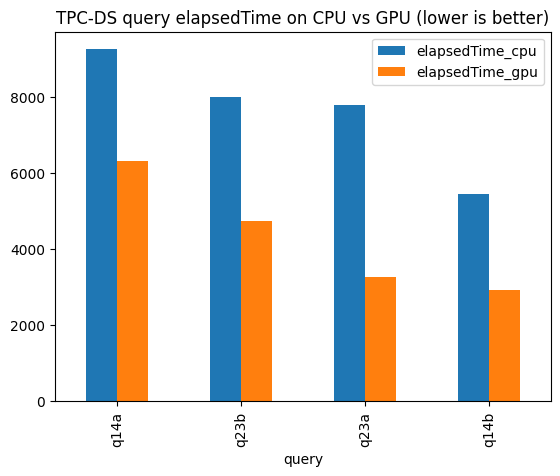

In [15]:
res.plot(title='TPC-DS query elapsedTime on CPU vs GPU (lower is better)', kind='bar', x='query', y=['elapsedTime_cpu', 'elapsedTime_gpu'])

<Axes: title={'center': 'Speedup factors of TPC-DS queries on GPU'}, xlabel='query'>

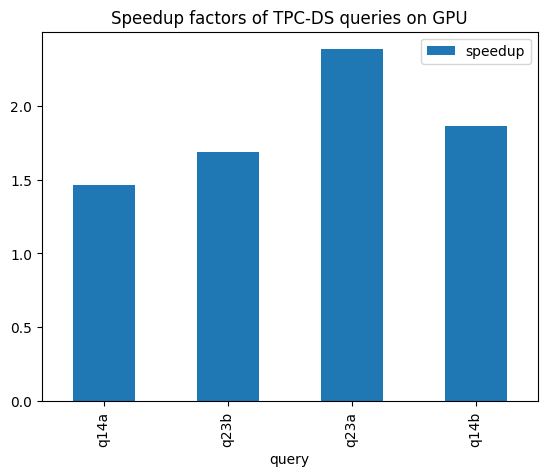

In [16]:
res.plot(title='Speedup factors of TPC-DS queries on GPU', kind='bar', x='query', y='speedup' )

# Run Queries interactively

In [17]:
query = 'q88'
with open(f"{tpcds_pyspark_files}/Queries/{query}.sql") as f:
  q = f.read()

In [18]:
print(q)

SELECT *
FROM
  (SELECT count(*) h8_30_to_9
  FROM store_sales, household_demographics, time_dim, store
  WHERE ss_sold_time_sk = time_dim.t_time_sk
    AND ss_hdemo_sk = household_demographics.hd_demo_sk
    AND ss_store_sk = s_store_sk
    AND time_dim.t_hour = 8
    AND time_dim.t_minute >= 30
    AND (
    (household_demographics.hd_dep_count = 4 AND household_demographics.hd_vehicle_count <= 4 + 2)
      OR
      (household_demographics.hd_dep_count = 2 AND household_demographics.hd_vehicle_count <= 2 + 2)
      OR
      (household_demographics.hd_dep_count = 0 AND
        household_demographics.hd_vehicle_count <= 0 + 2))
    AND store.s_store_name = 'ese') s1,
  (SELECT count(*) h9_to_9_30
  FROM store_sales, household_demographics, time_dim, store
  WHERE ss_sold_time_sk = time_dim.t_time_sk
    AND ss_hdemo_sk = household_demographics.hd_demo_sk
    AND ss_store_sk = s_store_sk
    AND time_dim.t_hour = 9
    AND time_dim.t_minute < 30
    AND (
    (household_demographics.hd_

In [19]:
spark.conf.set('spark.rapids.sql.enabled', True)
df  = spark.sql(q)
%time df.collect()

CPU times: user 3.84 ms, sys: 2.88 ms, total: 6.73 ms
Wall time: 2.13 s


[Row(h8_30_to_9=18440, h9_to_9_30=39156, h9_30_to_10=38666, h10_to_10_30=58037, h10_30_to_11=58313, h11_to_11_30=34436, h11_30_to_12=33322, h12_to_12_30=39142)]